In [1]:
import imageio
from pathlib import Path
import matplotlib.pyplot as plt
import pandas
import pickle
import numpy
import os
from skimage.filters import gaussian
import sys
from tqdm import tqdm
import matplotlib.gridspec as gridspec

repo_path = str(Path().resolve().parent.parent)
os.chdir(repo_path)
sys.path.append(repo_path)

from src.satellite_image_processing.normalize_index import (
    create_ndti_raster,
    create_ndwi_raster
)

In [2]:
image_class_path_list = list(filter(lambda path: "2022" in str(path), list(Path("data/bouctouche_class").iterdir())))

In [3]:
image_list = []
for image_class_path in image_class_path_list:
    with open(image_class_path, "rb") as f:
        image_list.append(pickle.load(f))

In [4]:
image_list_no_cloud = []
for image in image_list:
    if image.calculated_cloud_coverage < 0.01:
        image_list_no_cloud.append(image)

In [5]:
tides = pandas.read_csv("data/1805-01-MAY-2022_slev.csv", delimiter=",", skiprows=6, usecols=[0,1])
tides.columns = ["datetime", "height"]

In [19]:
img_index_for_water_mask = 3
ndwi = create_ndwi_raster(image_list_no_cloud[img_index_for_water_mask].green_band, image_list_no_cloud[img_index_for_water_mask].nir_band)
water_mask = numpy.atleast_3d((ndwi > 0.01)*1)[:600, :1500, :]
rgb = image_list_no_cloud[img_index_for_water_mask].get_rgb_float_true_color_image()[:600, :1500, :]
for img_index in tqdm(range(len(image_list_no_cloud))):
    rgb = image_list_no_cloud[img_index].true_color_image[:600, :1500, :]
    fig = plt.figure(figsize=(10, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    axs = [plt.subplot(gs[0]), plt.subplot(gs[1])]
    date = image_list_no_cloud[img_index].date.split("T")[0]
    try:
        tide_height = tides[tides["datetime"] == date.replace("-", "/") + " 15:00"]["height"].values[0]
    except:
        tide_height = 0
    ndti = numpy.atleast_3d(create_ndti_raster(image_list_no_cloud[img_index].red_band, image_list_no_cloud[img_index].green_band))[:600, :1500]
    alpha_array = (numpy.ones_like(water_mask)*0.70*water_mask)[:600,:1500,0]
    axs[0].imshow(rgb)
    axs[0].imshow(ndti*water_mask, cmap="Reds",alpha=alpha_array, vmin=-0.15, vmax=0.35)
    axs[0].axis("off")
    axs[1].bar([0], [tide_height])
    axs[1].set_ylim(0, 3)
    axs[1].set_xticks([0], ["tide_height"])
    axs[1].set_xticks([0], ["tide_height"])
    axs[1].text(0, tide_height, str(tide_height), ha='center', va='bottom')
    axs[1].set_title("Tide Height")
    fig.suptitle(date)
    plt.tight_layout()
    plt.savefig(f"data/bouctouche_turbidity_img/tci/{date}.png")
    plt.close()

  6%|▋         | 1/16 [00:00<00:07,  2.00it/s]C:\Users\ETE008168\OneDrive - INRS\Documents\turbidity_repo\turbidity-analysis\src\satellite_image_processing\normalize_index.py:51: RuntimeWarning: invalid value encountered in divide
  ndti = (red_band - green_band)/(red_band + green_band)
100%|██████████| 16/16 [00:07<00:00,  2.21it/s]


In [16]:
img_index_for_water_mask = 3
ndwi = create_ndwi_raster(image_list_no_cloud[img_index_for_water_mask].green_band, image_list_no_cloud[img_index_for_water_mask].nir_band)
water_mask = numpy.atleast_3d((ndwi > 0.01)*1)[:600, :1500, :]
rgb = image_list_no_cloud[img_index_for_water_mask].true_color_image[:600, :1500, :]
alpha_array = (numpy.ones_like(water_mask)*0.70*water_mask)[:600,:1500,0]
ndti_list = []
for img_index in tqdm(range(len(image_list_no_cloud))):
    ndti = create_ndti_raster(image_list_no_cloud[img_index].red_band, image_list_no_cloud[img_index].green_band)[:600, :1500]
    ndti_list.append(ndti)
ndti_list = numpy.array(ndti_list)

100%|██████████| 16/16 [00:00<00:00, 21.62it/s]


In [26]:
ndti_mean = numpy.atleast_3d(numpy.nanmean(ndti_list, axis=0))
ndti_var = numpy.atleast_3d(numpy.nanvar(ndti_list, axis=0))

(-0.5, 1499.5, 599.5, -0.5)

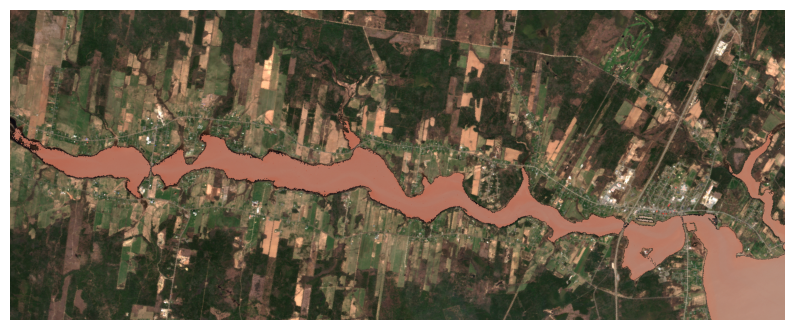

In [21]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(rgb)
plt.imshow(ndti_mean*water_mask, cmap="Reds",alpha=alpha_array, vmin=-0.15, vmax=0.35)
plt.axis("off")

In [40]:
(ndti_var > 0.005).mean()

0.12728555555555557

(-0.5, 1499.5, 599.5, -0.5)

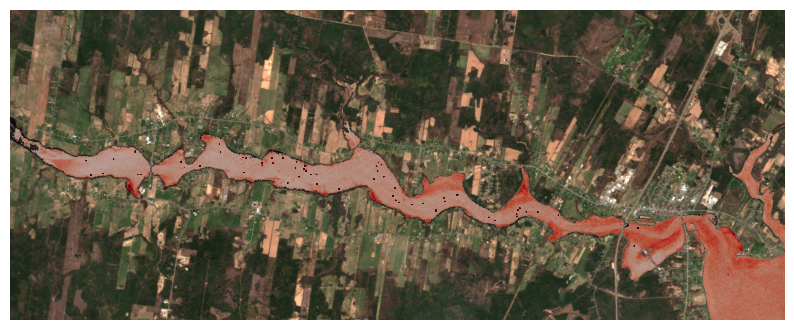

In [43]:
fig = plt.figure(figsize=(10, 5))
plt.imshow(rgb)
plt.imshow(ndti_var*water_mask, cmap="Reds",alpha=alpha_array, vmin=0, vmax=0.001)
plt.axis("off")

In [20]:
image_png_path_list = list(Path("data/bouctouche_turbidity_img/tci").iterdir())

In [21]:
frames = []
for image_png_path in image_png_path_list:
    image = imageio.v2.imread(image_png_path)
    frames.append(image)

In [22]:
imageio.mimsave(
    'bouctouche_tci.gif',
    frames,       
    duration=1000
)   

In [70]:
tides["height"].min()

0.2

In [71]:
tides["height"].max()

2.71